In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import sys
from pathlib import Path
import math

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.metrics import accuracy_score

# import custom functions from src folder
module_path = str(Path.cwd() / "../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from util import *

color = ["#e41a1c", "#377eb8"]

In [2]:
#Data constants

shapes_B = [2, 4]#[2, 2]
scales_B = [3, 3]
k_B = len(scales_B) # Number of classes
d_B = 2 # Number of dimensions
p_c_B = [1/len(shapes_B)]*len(shapes_B) # Uniform distributon over classes
tag_B = f'k_{k_B}_d{d_B}_shapes{shapes_B}_scales{scales_B}_pc{p_c_B}'.replace(" ", "")

trainfile_B = f"train_n_50000_{tag_B}"
testfile_B = f"test_n_10000_{tag_B}"
gridfile_B = f"grid_x1_x2_10000_{tag_B}"
large_gridfile_B = f"grid_r_a1_2500_{tag_B}"
test_data_B = pd.read_csv(f"data/{testfile_B}.csv")
grid_data_B = pd.read_csv(f"data/{gridfile_B}.csv")
large_grid_data_B = pd.read_csv(f"data/{large_gridfile_B}.csv")
train_data_B = pd.read_csv(f"data/{trainfile_B}.csv")
grid_xmax_B = grid_data_B["x1"].max()
large_grid_rmax_B = large_grid_data_B["r"].max()

shapes_A = [2, 6]#[2, 2]
scales_A = [5, 3]
k_A = len(scales_A) # Number of classes
d_A = 2 # Number of dimensions
p_c_A = [1/len(shapes_A)]*len(shapes_A) # Uniform distributon over classes
tag_A = f'k_{k_A}_d{d_A}_shapes{shapes_A}_scales{scales_A}_pc{p_c_A}'.replace(" ", "")

trainfile_A = f"train_n_50000_{tag_A}"
testfile_A = f"test_n_10000_{tag_A}"
gridfile_A = f"grid_x1_x2_10000_{tag_A}"
large_gridfile_A = f"grid_r_a1_2500_{tag_A}"
test_data_A = pd.read_csv(f"data/{testfile_A}.csv")
grid_data_A = pd.read_csv(f"data/{gridfile_A}.csv")
large_grid_data_A = pd.read_csv(f"data/{large_gridfile_A}.csv")
train_data_A = pd.read_csv(f"data/{trainfile_A}.csv")
grid_xmax_A = grid_data_A["x1"].max()
large_grid_rmax_A = large_grid_data_A["r"].max()

# Same for both data sets
n_train = [250, 1000, 5000]
n_plots = len(n_train)

max_err_val = [0]*n_plots
for i in range(n_plots):
    if n_train[i] < 1000:
        max_err_val[i] = 0.3
    else:
        max_err_val[i] = 0.3

In [3]:
from scipy.special import gamma as gamma

def gamma_distribution(x, alpha, beta):
    p_x = x**(alpha-1)*np.exp(-x*beta)*beta**(alpha)/(gamma(alpha))
    return p_x

def integral_gamma(r1, r2, alpha, beta):
    # Only works for positive integer values of alpha, positive values for beta
    sum_r1 = 0
    sum_r2 = 0
    n = alpha - 1
    # Sum over i in the range 0 to alpha -1
    for i in range (alpha):
        sum_r1 = sum_r1 + (r1*beta)**i/(math.factorial(i))
        sum_r2 = sum_r2 + (r2*beta)**i/(math.factorial(i))
    #print(sum_r1, sum_r2)
    integral = 1-np.exp(-beta*r2)*sum_r2 - (1-np.exp(-beta*r1)*sum_r1)
    return integral

def optimal_binwidth(x, alpha, beta, N):
    c1 = 1 #Rectangular kernel
    c2 = (1/24)**2 #Rectangular kernel
    d2gamma = gamma_distribution(x,alpha, beta)*(((alpha-1)/x-beta)**2-(alpha-1)/(x**2))
    h5 = N*c1*gamma_distribution(x, alpha, beta)/(4*c2*d2gamma**2)
    print(f"r={x}, h={h5**(1/5)}, N^(1/5)={N**(1/5)}, gamma(r)= {gamma_distribution(x, alpha, beta)}, gamma''(r) = {d2gamma}")
    return h5**(1/5)

def probability_r(r, alpha, beta, N):
    h = optimal_binwidth(r, alpha, beta, N)
    return integral_gamma(r - h/2, r + h/2, alpha, beta)

def mean_r_gamma(r1, r2, alphas, thetas, P_c):
    # Hackjob
    thetas = np.array(thetas)
    r_list = np.linspace(r1, r2, 200)
    p_r_list_c0 = gamma_distribution(r_list, alphas[0], 1/thetas[0])
    p_r_list_c1 = gamma_distribution(r_list, alphas[1], 1/thetas[1])
    p_r_list = p_r_list_c0*P_c+p_r_list_c1*P_c
    weights = p_r_list/(p_r_list.sum())
    weighted_avg_r = np.average(r_list, weights=weights)
    #print(r1, r2, weighted_avg_r)
    return weighted_avg_r

def expected_posterior(df, N, shapes, scales, bins=20):
    #Let's try some partitioning
    P_c = 0.5
    avg_mean = P_c*shapes[0]*scales[0]+ P_c*shapes[1]*scales[1]
    avg_var = P_c*shapes[0]*scales[0]**2+ P_c*shapes[1]*scales[1]**2
    r_max = avg_mean + 5*avg_var**(1/2) #df["r"].max()

    if N > 0:
        #bins = int((20*N)**(1/3))
        #bins = 30
        binwidth = r_max/bins
        #binwidth = 20*(0.5*shapes[0]*scales[0]**2 + 0.5*shapes[1]*scales[1]**2)**(-1/2)*(N)**(-1/3)
        #print("std p_r", (0.5*shapes[0]*scales[0]**2 + 0.5*shapes[1]*scales[1]**2)**(-1/2))
        #bins = 1 + int(np.log2(N))
        #bins = int(r_max/binwidth)
        print("Number of bins: ", bins, " binwidth: ", binwidth, "r_max: ", r_max)
        r_list = np.linspace(0, bins*binwidth, bins)
        P_r_and_c0 = np.zeros(len(r_list)-1)
        P_r_and_c1 = np.zeros(len(r_list)-1)
        exp_r = np.zeros(len(r_list)-1)
        for i in range(1, len(r_list)):
            P_r_and_c0[i-1] = integral_gamma(r_list[i-1], r_list[i], shapes[0], 1/scales[0])*P_c
            P_r_and_c1[i-1] = integral_gamma(r_list[i-1], r_list[i], shapes[1], 1/scales[1])*P_c
            exp_r[i-1] = mean_r_gamma(r_list[i-1], r_list[i], shapes, scales, P_c)

        exp_n_c0 = N*P_r_and_c0
        exp_n_c1 = N*P_r_and_c1
    #print(np.sum(exp_n_c0+exp_n_c1))
    else:
        binwidth=1
        r_list = 0 + np.arange(0, r_max//binwidth)*binwidth
        exp_n_c0 = N
        exp_n_c1 = N
        exp_r = r_list[0:-1] + binwidth/2

    df = pd.DataFrame(columns=["r", "exp_n_c0", "exp_n_c1", "exp_mean_f", "exp_std_f"])
    df["r"] = exp_r
    df["r_avg_simple"] = r_list[0:-1] + binwidth/2
    #print(np.array(r_list[0:-1]) + binwidth/2 - exp_r)
    df["exp_n_c0"] = exp_n_c0
    df["exp_n_c1"] = exp_n_c1
    df["exp_n"] = exp_n_c0 + exp_n_c1
    df["exp_mean_f1"] = (df["exp_n_c1"] + 1)/(df["exp_n"]+2)
    df["exp_var_f1"] = (df["exp_mean_f1"])*(1-df["exp_mean_f1"])/(df["exp_n"]+3)
    df["exp_std_f1"] = np.sqrt(df["exp_var_f1"])

    #df[f"exp_p_c1_given_r"] = (N*df[f"p_c1_given_r"]*df[f"p_r"] + 1)/(N*df[f"p_r"]+2)
    #df[f"exp_var_p_c1_given_r"] = (df[f"exp_p_c1_given_r"])*(1-df[f"exp_p_c1_given_r"])#/(N*df[f"p_r"]+3)
    #df[f"exp_std_p_c1_given_r"] = np.sqrt(df[f"exp_var_p_c1_given_r"])
    if (df["exp_n"].sum() -2 > N) or (df["exp_n"].sum() +2 < N):
        #Print if there is some descrepancy. We expect to trigger this as we increase N.
        print("WARNING:")
        print("Number of events", N, " Expected nr of events within 0, ", r_max, ": ", df["exp_n"].sum())
    return df


Number of bins:  20  binwidth:  2.5027756377319945 r_max:  50.05551275463989
Number of bins:  20  binwidth:  1.749038105676658 r_max:  34.98076211353316
Number of bins:  20  binwidth:  2.5027756377319945 r_max:  50.05551275463989
Number of events 5000  Expected nr of events within 0,  50.05551275463989 :  4996.646078258649
Number of bins:  20  binwidth:  1.749038105676658 r_max:  34.98076211353316
Number of events 5000  Expected nr of events within 0,  34.98076211353316 :  4992.2862927411115
Number of bins:  20  binwidth:  2.5027756377319945 r_max:  50.05551275463989
Number of events 10000  Expected nr of events within 0,  50.05551275463989 :  9993.292156517298
Number of bins:  20  binwidth:  1.749038105676658 r_max:  34.98076211353316
Number of events 10000  Expected nr of events within 0,  34.98076211353316 :  9984.572585482223


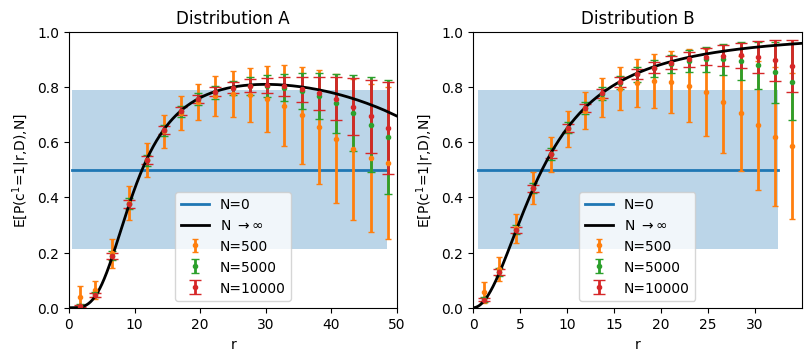

In [4]:
n_bin_list = [20]

for bins in n_bin_list:
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 3.5), layout="constrained")
    n_list = [0, 500, 5000, 10000]

    for i in range(len(n_list)):
        # Add posteriors for flat priors
        n = n_list[i]
        df_posterior_A = expected_posterior(test_data_A, n, shapes_A, scales_A, bins)
        df_posterior_B = expected_posterior(test_data_B, n, shapes_B, scales_B, bins)
        if n == 0:
            sn.lineplot(df_posterior_A, x="r", y="exp_mean_f1", ax = axs[0], linewidth=2, label=f"N={n}")
            axs[0].fill_between(df_posterior_A["r"], df_posterior_A["exp_mean_f1"] - df_posterior_A["exp_std_f1"], 
                                df_posterior_A["exp_mean_f1"] + df_posterior_A["exp_std_f1"], alpha=0.3)
            sn.lineplot(df_posterior_B, x="r", y="exp_mean_f1", ax = axs[1], linewidth=2, label=f"N={n}")
            axs[1].fill_between(df_posterior_B["r"], df_posterior_B["exp_mean_f1"] - df_posterior_B["exp_std_f1"], 
                                df_posterior_B["exp_mean_f1"] + df_posterior_B["exp_std_f1"], alpha=0.3)
        else:
            axs[0].errorbar(df_posterior_A["r"], df_posterior_A["exp_mean_f1"], yerr=df_posterior_A["exp_std_f1"], 
                            markersize=3, elinewidth=2, capsize=i+1, fmt="o", label=f"N={n}")
            axs[1].errorbar(df_posterior_B["r"], df_posterior_B["exp_mean_f1"], yerr=df_posterior_B["exp_std_f1"], 
                            markersize=3, elinewidth=2, capsize=i+1, fmt="o", label=f"N={n}")
        #sn.lineplot(df_posterior_A, x="r", y="exp_mean_f1", ax = axs[0], linewidth=2, label=f"N={n}")
        #axs[0].fill_between(df_posterior_A["r"], df_posterior_A["exp_mean_f1"] - df_posterior_A["exp_std_f1"], df_posterior_A["exp_mean_f1"] + df_posterior_A["exp_std_f1"], alpha=0.3)
        #sn.lineplot(df_posterior_B, x="r", y="exp_mean_f1", ax = axs[1], linewidth=2, label=f"N={n}")
        #axs[1].fill_between(df_posterior_B["r"], df_posterior_B["exp_mean_f1"] - df_posterior_B["exp_std_f1"], df_posterior_B["exp_mean_f1"] + df_posterior_B["exp_std_f1"], alpha=0.3)

    sn.lineplot(test_data_A, x="r", y="p_c1_given_r", ax = axs[0], c="black", linewidth=2, label=r"N $\rightarrow \infty$")
    axs[0].set_title(f"Distribution A")
    axs[0].set_ylabel(r"E[P(c$^1$=1|r,D),N]")
    axs[0].set_ylim(0,1)
    axs[0].set_xlim(0,grid_xmax_A)
    sn.lineplot(test_data_B, x="r", y="p_c1_given_r", ax = axs[1], c="black", linewidth=2, label=r"N $\rightarrow \infty$")
    axs[1].set_title(f"Distribution B")
    axs[1].set_ylabel(r"E[P(c$^1$=1|r,D),N]")
    axs[1].set_ylim(0,1)
    axs[1].set_xlim(0,grid_xmax_B)

fig.savefig("fig/expected_posterior.pdf", format="pdf", bbox_inches='tight', dpi=350)


Number of bins:  20  binwidth:  2.5027756377319945 r_max:  50.05551275463989
Number of bins:  20  binwidth:  1.749038105676658 r_max:  34.98076211353316
Number of bins:  20  binwidth:  2.5027756377319945 r_max:  50.05551275463989
Number of events 5000  Expected nr of events within 0,  50.05551275463989 :  4996.646078258649
Number of bins:  20  binwidth:  1.749038105676658 r_max:  34.98076211353316
Number of events 5000  Expected nr of events within 0,  34.98076211353316 :  4992.2862927411115
Number of bins:  20  binwidth:  2.5027756377319945 r_max:  50.05551275463989
Number of events 10000  Expected nr of events within 0,  50.05551275463989 :  9993.292156517298
Number of bins:  20  binwidth:  1.749038105676658 r_max:  34.98076211353316
Number of events 10000  Expected nr of events within 0,  34.98076211353316 :  9984.572585482223


Text(0, 0.5, 'E[s|r-$\\Delta r \\leq r \\leq r + \\Delta r$ ]')

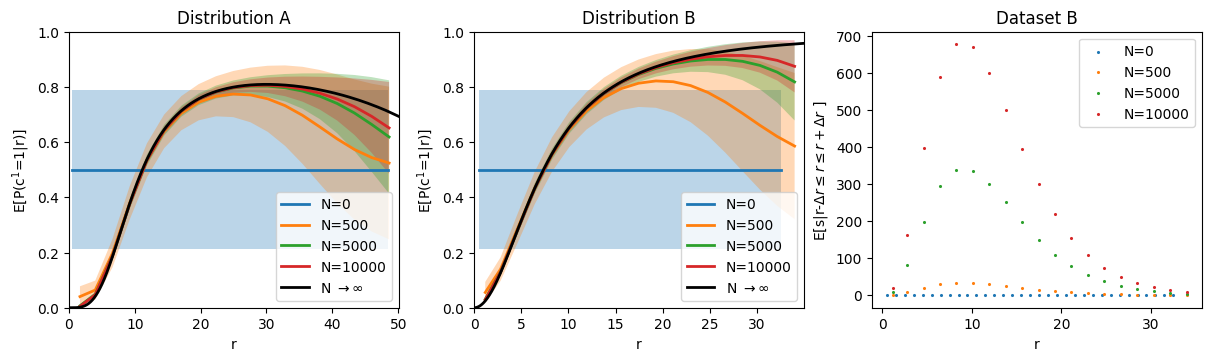

In [5]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 3.5), layout="constrained")
n_list = [0, 500, 5000, 10000]
for i in range(len(n_list)):
    # Add posteriors for flat priors
    n = n_list[i]
    df_posterior_A = expected_posterior(test_data_A, n, shapes_A, scales_A)
    df_posterior_B = expected_posterior(test_data_B, n, shapes_B, scales_B)
    sn.lineplot(df_posterior_A, x="r", y="exp_mean_f1", ax = axs[0], linewidth=2, label=f"N={n}")
    axs[0].fill_between(df_posterior_A["r"], df_posterior_A["exp_mean_f1"] - df_posterior_A["exp_std_f1"], df_posterior_A["exp_mean_f1"] + df_posterior_A["exp_std_f1"], alpha=0.3)
    sn.lineplot(df_posterior_B, x="r", y="exp_mean_f1", ax = axs[1], linewidth=2, label=f"N={n}")
    sn.scatterplot(df_posterior_B, x="r", y="exp_n_c1", ax = axs[2], linewidth=0, s=5, label=f"N={n}")
    axs[1].fill_between(df_posterior_B["r"], df_posterior_B["exp_mean_f1"] - df_posterior_B["exp_std_f1"], df_posterior_B["exp_mean_f1"] + df_posterior_B["exp_std_f1"], alpha=0.3)

sn.lineplot(test_data_A, x="r", y="p_c1_given_r", ax = axs[0], c="black", linewidth=2, label=r"N $\rightarrow \infty$")
axs[0].set_title(f"Distribution A")
axs[0].set_ylabel(r"E[P(c$^1$=1|r)]")
axs[0].set_ylim(0,1)
axs[0].set_xlim(0,grid_xmax_A)
sn.lineplot(test_data_B, x="r", y="p_c1_given_r", ax = axs[1], c="black", linewidth=2, label=r"N $\rightarrow \infty$")
axs[1].set_title(f"Distribution B")
axs[1].set_ylabel(r"E[P(c$^1$=1|r)]")
axs[1].set_ylim(0,1)
axs[1].set_xlim(0,grid_xmax_B)

axs[2].set_title(f"Dataset B")
axs[2].set_ylabel(r"E[s|r-$\Delta r \leq r \leq r + \Delta r$ ]")
#fig.savefig("fig/expected_posterior.png")
